In [1]:
import os
import cv2 
import numpy as np
from scipy.ndimage import interpolation as inter
import imutils
import scipy.signal as signal

In [2]:
def white_band(img, side):
    """ 
    Determine best position to crop image

    Parameters:
    img (array): Image
    type (str) : Side of image to crop
    
    Returns:
    (int): Position on image to crop
    """
    h, w, c = img.shape
    pixel_size = 1 

    if side in ["top", "bottom"]:
        # Calculate white pixels at each slice   
        hist = np.sum(img/255, axis=1)[:, 0]   
        y = np.add.reduceat(hist, np.arange(0, len(hist), pixel_size))
        x = np.arange(0, len(hist),pixel_size)
        # Select indices to analyse image at specific area
        if side == "top":
            ind = x[x<h*0.2]    
        elif side == "bottom":
            ind = x[x>h*0.8]
    elif side == "center":
        # Calculate white pixels at each slice   
        hist = np.sum(img/255, axis=0)[:, 0]
        y = np.add.reduceat(hist, np.arange(0, len(hist), pixel_size))
        x = np.arange(0, len(hist), pixel_size)
        # Select indices to analyse image at specific area
        ind = x[np.logical_and(x<w*0.7, x>w*0.3)]
    else:
        raise ValueError('Wrong side input')

    grd = np.gradient(y[ind])
    grd[np.logical_and(grd<np.std(grd)/2, grd>-np.std(grd)/2)] = 0  # Flatten noise within half sd
    nonzero = np.where(np.diff(grd)!=0)[0] # Determine largest white band
    crop = np.mean([nonzero[np.argmax(np.diff(nonzero))+1], 
                    nonzero[np.argmax(np.diff(nonzero))]]) # Center of white band 

    return round(crop+ind[0])

In [105]:
def rotation_angle(img):
    """Determine the best angle to rotate the image to remove skew.
    
    Input:
    img (array): Image
    
    Returns:
    (int): Angle 
    """
    img = img/255 # Convert image to bitwise

    h,w,c = img.shape
    zoom = img[:, round(w*0.4):round(w*0.6)]
   
    delta = 0.1
    limit = 2

    angles = np.arange(-limit, limit+delta, delta)
    scores = []
    for angle in angles:
        # hist, score = find_score(img, angle)
        # scores.append(score)
        scores.append(white_length(zoom, angle))
    
    best_score = max(scores)
    best_angle = angles[scores.index(best_score)]
    
    return float(best_angle)

In [12]:
def find_score(arr, angle):
    """ Determine score for a given rotation angle.
    """
    data = imutils.rotate_bound(arr, angle)
    hist = np.sum(data, axis=1)
    score = np.sum((hist[1:] - hist[:-1]) ** 2)
    return hist, score

In [8]:
def binarise(img):
    """ Convert image into black and white
    """
    thresh_val = 150 # Chosen through trial and error
    th,image_b = cv2.threshold(src=img, thresh=thresh_val, maxval=255, type=cv2.THRESH_BINARY)
    return image_b

In [9]:
def preprocess(page, img, loc):
    """ Process and save image file for OCR

    Inputs:
    img (array): Single page from book
    page (int): Page number of image
    loc (string): Folder to save images to
    """    
    if np.mean(img)<245:
        # Fix Skew
        angle = rotation_angle(img)
        img_rotate= imutils.rotate_bound(255-img, angle)

        invert_im = 255-img_rotate

        # Define image dimensions to crop
        bottom = white_band(invert_im, "bottom")
        top = white_band(invert_im, "top")
        center = white_band(invert_im, "center")

        # Split two column of text into separate images
        left_col =invert_im[top:bottom, : center]
        right_col =invert_im[top:bottom, center: ]

        cv2.imwrite(os.path.join(loc, page + "_L.png"), left_col)
        cv2.imwrite(os.path.join(loc, page + "_R.png"), right_col)

    else:
        print(page, np.mean(bin_img))

# Quien es Quien 1961

In [131]:
folder = "folder"
first_page = 6 # Page number of first image

#for count, filename in enumerate(os.listdir(folder)):
    im = cv2.imread(os.path.join(folder, filename))
    bin_im = binarise(im)
    center = white_band(bin_im, "center")

    # Split page into two images
    im_left = bin_im[50:, :center]
    im_right = bin_im[50:, center:]

    # Determine page numbers
    left_page_num = str(first_page+count*2)
    left_pg = "0"*(3-len(left_page_num)) + left_page_num 
    right_page_num = str(first_page+count*2+1)
    right_pg = "0"*(3-len(right_page_num)) + right_page_num 

    # Preprocess images
    preprocess(left_pg, im_left, "Processed Images")
    preprocess(right_pg, im_right, "Processed Images")

006 240.5375988546496
122 240.5375988546496
184 240.5375988546496
200 240.5375988546496
282 240.5375988546496
312 240.5375988546496
358 240.5375988546496


# Quien es Quien 1948

In [106]:
folder = "Quien es Quien 1948"
first_page = 19 # Page number of first image

for count, filename in enumerate(os.listdir(folder)):
    im = cv2.imread(os.path.join(folder, filename))
    bin_im = binarise(im)
    crop_im = bin_im[200:, :]

    # Determine page numbers
    page_num = str(count+first_page)
    page_num = "0"*(3-len(page_num)) + page_num 

    # Preprocess images
    preprocess(page_num, crop_im, "1948")

KeyboardInterrupt: 

In [103]:
im = cv2.imread("010.jpg")
bin_im = binarise(im)
crop_im = bin_im[200:, :]

# Fix Skew
angle = rotation_angle(crop_im)

In [104]:
img = crop_im/255 # Convert image to bitwise

h,w,c = img.shape
zoom = img[:, round(w*0.4):round(w*0.6)]
   
delta = 0.1
limit = 2

angles = np.arange(-limit, limit+delta, delta)
scores = []
for angle in angles:
    scores.append(white_length(zoom,angle))
    
best_score = max(scores)
best_angle = float(angles[scores.index(best_score)])
print(best_angle)

-2.5


In [86]:
def white_length(img, angle):
    data = imutils.rotate_bound(1-img, angle)
    hist = np.sum(1-data, axis=0)[:, 0]
    peaks, ht = signal.find_peaks(hist, 1750)
    if len(peaks)>0:
        max_height = max(ht["peak_heights"])
        return max_height
    else:
        return 0

In [63]:
data = imutils.rotate_bound(1-img, angle)
hist = np.sum(1-data, axis=0)[:, 0]

In [67]:
peaks, ht = signal.find_peaks(hist, 1500)
max_height = max(ht["peak_heights"][1:-1])

In [68]:
max_height

1903.4189453125

In [503]:
peaks

array([  3, 306, 311, 315], dtype=int64)

In [52]:
data = imutils.rotate_bound(1-zoom, -2)
hist = np.sum(1-data, axis=0)
score = np.sum((hist[1:] - hist[:-1]) ** 2)

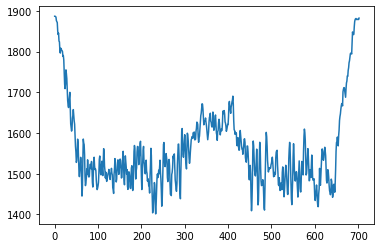

In [55]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(hist[:,0])), hist[:,0])

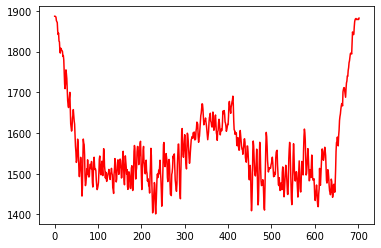

In [56]:
data = imutils.rotate_bound(1-zoom, -2)
hist = np.sum(1-data, axis=0)
plt.plot(np.arange(len(hist)), hist[:,0], color = "red")
plt.show()

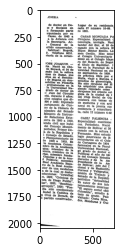

In [17]:
plt.imshow(1-data)

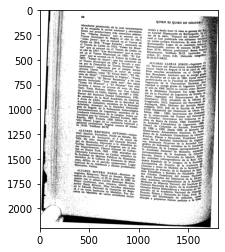

In [102]:
img_rotate= imutils.rotate_bound(255-crop_im, 2.3)
img = 255-img_rotate
plt.imshow(img)

In [89]:
h, w, c = img.shape
pixel_size = 1 

hist = np.sum(img/255, axis=0)[:, 0]
y = np.add.reduceat(hist, np.arange(0, len(hist), pixel_size))
x = np.arange(0, len(hist), pixel_size)
# Select indices to analyse image at specific area
ind = x[np.logical_and(x<w*0.7, x>w*0.3)]

In [90]:
grd = np.gradient(y[ind])
grd[np.logical_and(grd<np.std(grd)/2, grd>-np.std(grd)/2)] = 0  # Flatten noise within half sd
nonzero = np.where(np.diff(grd)!=0)[0] # Determine largest white band
crop = np.mean([nonzero[np.argmax(np.diff(nonzero))+1], 
                nonzero[np.argmax(np.diff(nonzero))]]) # Center of white band 

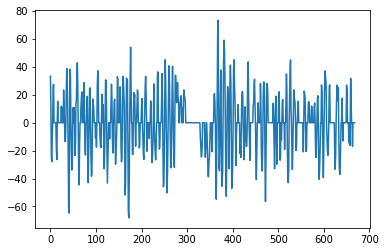

In [91]:
import matplotlib.pyplot as plt

plt.plot(np.arange(len(grd)), grd)

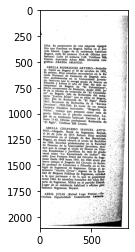

In [92]:
plt.imshow(img[:, round(crop+ind[0]):])

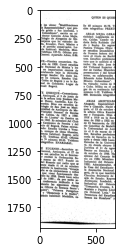

In [48]:
plt.imshow(img[:, round(w*0.3):round(w*0.7)])